# CQF - Exam 2 2021/04/18
#### delegate: Zhenyang Lu, zzhenyanglu@gmail.com

## 0. Before we begin the quant finance - normal distribution random number generator
 
I'd define my own uniform (to generate normal) and normal distribution(s) random number generator using Box-Muller algo (for fun ^_^). 

### RANDU - uniform distribution (0,1) random number generator 

Below is an implement of RANDU algo based on wikipedia: https://en.wikipedia.org/wiki/RANDU 

In [1]:
import numpy as np 

class RANDOM(object):
    _SOME_PRIMER_NUMBER = 66539
    _MOD = 2.0**31
    
    # takes a seed number as initial V or V zero from the wiki page 
    def __init__(self):
        self.seed()
        self.V = self.seed 

    def seed(self, seed=None):
        if seed:
            self.seed = seed
        else:
            import random
            self.seed = random.randint(0, RANDOM._MOD)
            
    # function to generate uniform(0,1) number
    def uniform(self, seed=None):
        self.V = (RANDOM._SOME_PRIMER_NUMBER*self.V) % RANDOM._MOD
        return float(self.V)/RANDOM._MOD

### Box Muller - define a normal distribution (mu, sigma) random number generator based on RANDU

reference: https://en.wikipedia.org/wiki/Marsaglia_polar_method 

In [2]:
# define RANDOM as its own parent to skip repeating definition of uniform method

class RANDOM(RANDOM):
    def normal(self, mu=0.0, sigma=1.0):
        while True:
            U, V = 2*self.uniform()-1, 2*self.uniform()-1
            R = U**2+V**2
            if R<1: break

        z0 = np.sqrt(-2.0*np.log(R)/R)*U
        self.z1 = np.sqrt(-2.0*np.log(R)/R)*V
                
        return mu+sigma*z0

### Test normality 

The following test (alpha = 0.001) uses scipy's normaltest function which has the $ null$  $hypothesis $ that 

     h0: sample distribution comes from a normal distribution. 
 
It is based on D’Agostino and Pearson’s test that combines skew and kurtosis to produce an omnibus test of normality.

My own random normal distribution number generator works fine.

reference: https://docs.scipy.org/doc/scipy/reference/generated/scipy.stats.normaltest.html

In [3]:
from scipy import stats

N = 100000
alpha = 1e-3

rand = RANDOM()
random_numbers = [rand.normal() for i in range(N)]
k2, p = stats.normaltest(random_numbers)
print("p = {:g}".format(p))

if p < alpha:  # null hypothesis: x comes from a normal distribution
    print("Test Result: The null hypothesis can be rejected")
else:
    print("Test Result: The null hypothesis cannot be rejected")

p = 0.468883
Test Result: The null hypothesis cannot be rejected


## 1. Numerical Procedure of Binary Option MC simulation 

### 1.1 Define a generic European binary option object 

0.  $dX$ is iid normal random variables N(0,${\displaystyle dt}$) (which is generated by RANDOM.normal funtion), according to Eulr-Maruyama method 


1. Function delta_S is based on    $ dS = a(S, t) dt + b(S, t) dX$  where $ a(S, t) = r*S$ and $ b(S, t) = \sigma*S $ since it's risk neutral density 
     
     
2. Rule to update S would be $ S_{t} = S_{t-1} +  dS $, where dS is from 1.

In [43]:
import numpy as np 

class OptionType():
    Call = 0
    Put = 1

class BinaryOption(object):
    def __init__(self, S, E, r, sigma, T, D=0, option_type=OptionType.Call):
        """
        parameters: 
            S=underlying spot price
            E=strike price
            r=interest rate
            sigma=volatility
            T=time to expiry in year
            D=underlying dividend
        """
        self.S, self.E, self.r, self.sigma, self.T, self.D = S, E, r, sigma, T, D
        
        if option_type not in (OptionType.Call, OptionType.Put):
            raise NotImplemented("Unknown option type")

        self.option_type = option_type
        # make a new copy of self.S for simulation, so mathly, S_t = S_{t-i} + delta_S
        self.S_t = self.S
        self.random = RANDOM()
    
    # this is value*e^(-rt)
    def present_value(self, value, t):
        return value*np.exp(-self.r*t)
    
    def _heaviside(self, x):
        return float(x>0)  # return 1.0 or 0.0
     
    def payoff(self):
        if self.option_type == OptionType.Put:
            return self._heaviside(self.E-self.S_t)
        elif self.option_type == OptionType.Call:
            return self._heaviside(self.S_t-self.E)

    # weiner process with N(0,sqrt(dt))
    def get_dX(self, mu, sigma):
        self.dX = self.random.normal(mu, sigma)
        return self.dX
    
    # this is dS = a(S,t)dt+b(S, t)dX 
    def get_delta_S(self, dt, mu=None, sigma=None): 
        """parameters:
               mu: mean of the weiner process
               sigma: sigma of the weiner process
        """
        sigma = sigma if sigma else np.sqrt(dt)
        mu = mu if mu else 0
        self.delta_S = self.a()*dt + self.b()*self.get_dX(mu, sigma)

        return self.delta_S

    # S_t = S_{t-1} + dS 
    def update_S_t(self, dt):
        self.S_t = self.S_t + self.get_delta_S(dt)
        return self.S_t
    
    # a=a(S,t) from dS = a(S,t)dt + b(S,t)dX
    def a(self):
        return self.r*self.S_t
    
    # b=b(S,t) from dS = a(S,t)dt + b(S,t)dX
    def b(self):
        return self.sigma*self.S_t

    def get_S_t(self):
        return self.S_t
    
    # reset S_t to S_0 which is inital underlying price
    # to start a new 
    def clear_path(self):
        self.S_t = self.S

### 1.2 Monte Carlo engine

In [192]:
from multiprocessing import Pool, Manager
import matplotlib.pyplot as plt
plt.style.use('seaborn-whitegrid')

class MCEngine():
    def __init__(self, option):
        """parameters: 
               option: (European) option object being simulated on  
        """
        self.option = option
    
    # quick tool to visualize MC simulated paths
    @staticmethod
    def visualize_paths(paths, graph_size = (16,12)):
        fig = plt.figure(figsize=graph_size)
        ax = plt.axes()
        x = np.linspace(0, len(paths[0]['path']), len(paths[0]['path']))
        
        for result in results:
            ax.plot(x, result['path'])
        fig.show()
        
    # quick tool to visualize MC errors
    @staticmethod
    def visualize_errors(errors, x = np.linspace(0, len(errors), len(errors)), graph_size = (16,12)):
        fig = plt.figure(figsize=graph_size)
        ax = plt.axes()
        ax.plot(x, errors)
        fig.show()
    
    # simulate 1 path, return terminal value of options'S
    def simulate_once(self, steps=1000, keep_path=False):
        """parameters:
               paths: collection of paths
               steps: number of steps in a single simulation 
               keep_path: if keep simulation path for analysis
        """
        dt = self.option.T/steps
        current_path = [ self.option.update_S_t(dt=dt) for _ in range(steps)]
        
        if not keep_path: 
             current_path = [current_path[-1]]

        payoff = self.option.payoff()
        self.option.clear_path()
        return {"path": current_path, "asset_terminal_price": current_path[-1], "option_payoff": payoff}

        
    # simulate n times each with steps step (dt=T/steps)
    def simulate_n_times(self, steps: int, n: int, keep_path: bool, terminal_price_only: bool = False):
        """parameters:
               steps: number of steps in a single simulation  
               keep_path: if keep simulation path for analysis
               n: number of simulation
               processes: number of processes to utilize
               terminal_price_only: only keep terminal pricess of the underlying asset for speed up
        """
        if terminal_price_only:
            return [self.simulate_once(steps=steps, keep_path=keep_path)['asset_terminal_price'] for _ in range(n)]
        return [self.simulate_once(steps=steps, keep_path=keep_path) for _ in range(n)]

## 1.3 A Quick MC Simulation Trial - Call option with Initial Example Arguments

Today stock price S = 100

Strike E = 100

Time to expiry T = 1 year

volatility = 20%

interest rate r = 5%

### Below is visualizing 1000 times simulations each with 200 steps (T = 1/200) of underlying asset price (S) :  

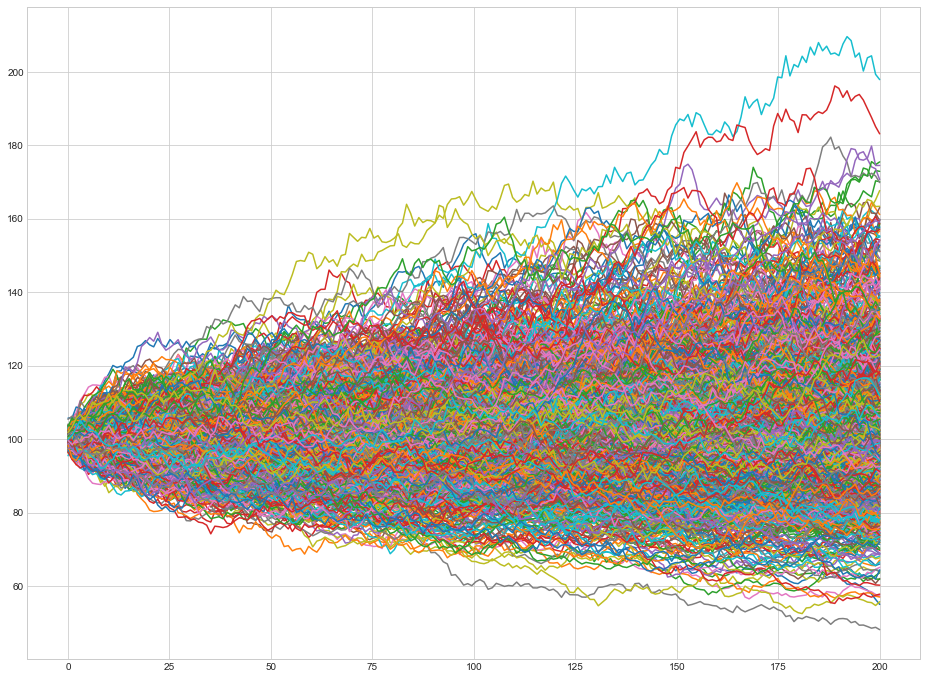

In [110]:
import warnings
warnings.filterwarnings('ignore')

option = BinaryOption(S=100, E=100, r=0.05, sigma=0.2, T=1, option_type=OptionType.Call)
mc_engine = MCEngine(option)
results = mc_engine.simulate_n_times(steps=200, n=1000, keep_path=True)
mc_engine.visualize_paths(results)

## 1.4 How to find the best number of simulations - Converge 

inspired by: https://quant.stackexchange.com/questions/21764/stopping-monte-carlo-simulation-once-certain-convergence-level-is-reached, below is how it works briefly: 

let $E(X)=\mu$ and $ Var(X)=\sigma$.According to CLT, if we sample large enough size, the terminal value of underlying asset (S) would be normally distribution, so we have 

 $ P(|\frac{X_{n}-\mu}{\frac{\sigma}{ \sqrt{n}}}| > Z_{p})  \approx  P(|Z| > Z_{p}) = p$

In words, there is approximately a 1-p probability that the sample mean $X_{n}$ is within $Z_{p} \frac{\sigma}{\sqrt{n}}$ units of the true mean μ.so we continue simulation until $X_{n}$ is within $Z_{p} \frac{\sigma}{\sqrt{n}} $ (the error terms below in the code) $ < \epsilon $, which is precision requirement. 

Rules to update $X_{n}$ and $Var(X)$ in each step:

1. $\bar{X_{n+1}} = \bar{X_{n}} + \frac{X_{n+1}-\bar{X_{n}}}{n+1}$ (1)

2. $S_{n+1}^2 = (1 - \frac{1}{n}) S_{n}^2 + (n+1)(\bar{X_{n+1}} - \bar{X_{n}})^2$ (2)

So the following is an implementation of this approach.  

### the mc engine here in this report would use `epsilon` arugment as the minimum accepted precision error ($\bar{X} - X$) for converge

In [211]:
import scipy.stats as st

class MCEngine(MCEngine):
    def simulate_until_converge(self, steps, on, epsilon=0.01, alpha=0.05, minimal_n=1000, hard_limit=int(1e7), keep_path=False):
        """parameters:
               steps: number of steps in a single simulation (dt=T/steps)
               on: converge on either payoff of binary or terminal_price of underlying
               epsilon: the min acceptable error term above 
               alpha: acceptance possibility
               minimal_n: minimal number of simulation performed 
               hard_limit: max times of simulation to stop no matter if converges
               keep_path: if keep simulation path for analysis
               
               n: number of simulation
               processes: number of processes to utilize
        """
        # X_n and S_n^2 above
        result = self.simulate_once(steps=steps, keep_path=keep_path)
        Xn = result[on]
        Varn = 0 
        Z = st.norm.ppf(1-alpha)
        threshold = epsilon/Z 
        errors = [] 
        
        for i in range(2, hard_limit):            
            result = self.simulate_once(steps=steps, keep_path=keep_path)
            value = result[on]
            new_Xn = Xn + (value - Xn)/(i)  # formula (1) above
            Varn = (1.0-1.0/(i))*Varn + (i-1)*np.square(new_Xn-Xn) # formula (2) above
            Xn = new_Xn
            error = np.sqrt(Varn/(i+1))
            errors.append(error)
            
            if error < threshold and i > minimal_n :
                print(f"Stopped at the {i} iteration")
                print(f"Expected value of {on} on binary {'PUT' if self.option.option_type ==1 else 'CALL'}: {Xn} with deviation of {np.sqrt(Varn)}")
                break
        else:
            print(f"Stopped at the hard limit iteration: {hard_limit}")
            return Xn, errors
                      
        return Xn, errors

## 1.5 validation result of simulation
### a. what's the terminal expected value of underlying asset at T when r=0.05, T=1, K=100 and S=100, Sigma=0.2 ? 

Given that the underlying asset follows risk neutral density, the analytical terminal value of underlying asset ($ S_{T}$) would be given by 

$ S_{T} = S*e^{r*T} = 100*e^{0.05*1} = 105.127$

what's the expected terminal value of the underly given by our MC simulation? The following code shows the simulated result, when the minimal tolerace is 0.05, is $ 105.12 $

So the fact that analytical result is close to simulated one means my MCEngine would look fine (I think)!  

In [103]:
import time

option = BinaryOption(S=100, E=100, r=0.05, sigma=0.2, T=1, option_type=OptionType.Call)
mc_engine = MCEngine(option)

start = time.time()
results, errors = mc_engine.simulate_until_converge(steps=200, on = "asset_terminal_price", epsilon=0.05)
print(f"Time took: {time.time() - start} seconds")

Stopped at the 487797 iteration
Expected value of asset_terminal_price on binary CALL: 105.11123828202874 with deviation of 21.230612725108433
Time took: 898.1899645328522 seconds


### b. what's the terminal expected value of binary PUT/CALL at T when r=0.05, T=1, Sigma=0.2, K=100 and S=100?

according to https://en.wikipedia.org/wiki/Binary_option#Cash-or-nothing_call.

The expected value of a binary CALL(C) and PUT(P) option at expiry T would be: 

$ C=e^{{-r*0}}\Phi (d_{2}) = \Phi (d_{2}) $    

$ P=e^{{-r*0}}\Phi (-d_{2}) = \Phi (-d_{2}) $

where $ d_{1}={\frac  {\ln {\frac  {S}{K}}+(r-q+\sigma ^{{2}}/2)T}{\sigma {\sqrt  {T}}}},\,d_{2}=d_{1}-\sigma {\sqrt  {T}} $

if we plug in q=0, r=0.05, T=1, K=100 and S=100, 

$ C=\Phi (d_{2}) = \Phi (0.15) = 0.56$  

where $ d_{1}={\frac  {\ln {\frac  {100}{100}}+(0-0+0.2^{{2}}/2)*1}{\sigma {\sqrt  {1}}}} = 0.35,\,d_{2}=d_{1}-0.2*{\sqrt{1}}=0.15$

what's the expected terminal value of the binary CALL by our MC simulation? The following code shows that a CALL would be worth 0.5589998320758923 very close to analytical results! 

In [104]:
import time

option = BinaryOption(S=100, E=100, r=0.05, sigma=0.2, T=1, option_type=OptionType.Call)
mc_engine = MCEngine(option)

start = time.time()
results, errors = mc_engine.simulate_until_converge(steps=200, on = "option_payoff", epsilon=0.001)
print(f"Time took: {time.time() - start} seconds")

Stopped at the 666940 iteration
Expected value of option_payoff on binary CALL: 0.5590862746274167 with deviation of 0.49649653790399556
Time took: 1220.1717183589935 seconds


$ P=\Phi (d_{2}) = \Phi (-0.15) = 0.44$  

what's the expected terminal value of the binary PUT by our MC simulation? The following code shows a PUT's worth 0.44033631594261213, very close to analytical results! 

In [210]:
option = BinaryOption(S=100, E=100, r=0.05, sigma=0.2, T=1, option_type=OptionType.Put)
mc_engine = MCEngine(option)

start = time.time()
results, errors = mc_engine.simulate_until_converge(steps=200, on = "option_payoff", epsilon=0.003)
print(f"Time took: {time.time() - start} seconds")

Stopped at the 74168 iteration
Expected value of option_payoff on binary PUT: 0.44273810807895714 with deviation of 0.496710253300277
Time took: 129.00511765480042 seconds


## 2. Results/Conclusions
### 2.0 how does the simulation converge (number of simulation versus (true value - expected value) )

the following graph shows the number of simulation versus ($\bar{X_{n}} - X_{n}$), like when ($\bar{X_{n}} - X_{n}$ is smaller than accepted epsilon in the `simulate_until_converge()` simulation is gonna stop), as we could see ($\bar{X_{n}} - X_{n}$) rapidly drops after an initial spike, but as the simulation proceeds it becomes very hard for ($\bar{X_{n}} - X_{n}$) to get smaller actually. Tried to explore so numerical tricks (primarily https://en.wikipedia.org/wiki/Control_variates) to reduce the variance hence making the converge more quickly, but couldn't figure out a good controlled quantity so give it up. 

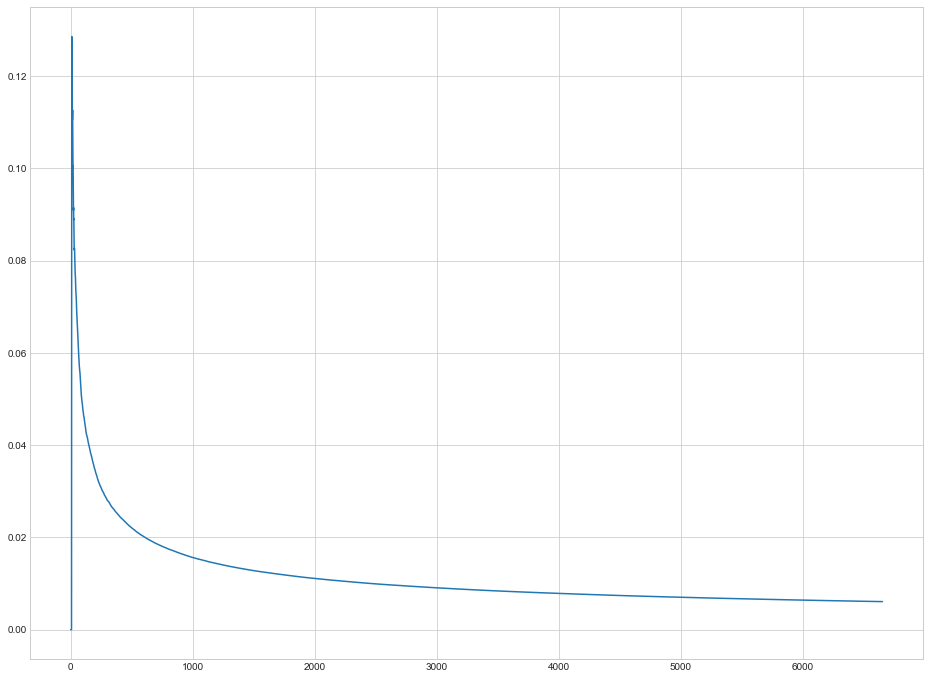

In [174]:
mc_engine.visualize_errors(errors)

### 2.1 error graphs 
below is the relationship between number of simulation and simulated binary PUT option payoff when S = 100, E=100, r=0.05, volatility = 20%, T=1. So it kinda follows the same pattern as converge graph from section 2.0, which declines rapidly initially, but becomes really hard to reach to theoretical value as the number of simulations goes up. 

In [ ]:
option = BinaryOption(S=100, E=100, r=0.05, sigma=0.2, T=1, option_type=OptionType.Put)
mc_engine = MCEngine(option)

n_simulations = [10, 20, 50, 100, 500, 1000, 2000, 5000, 8000, 10000, 20000, 50000, 80000, 100000, 200000, 300000, 500000]
 
expected_payoffs = []
for n_simulation in n_simulations:
    expected_payoffs.append(mc_engine.simulate_until_converge(steps=200, on = "option_payoff", hard_limit= n_simulation, epsilon=0.001)[0])

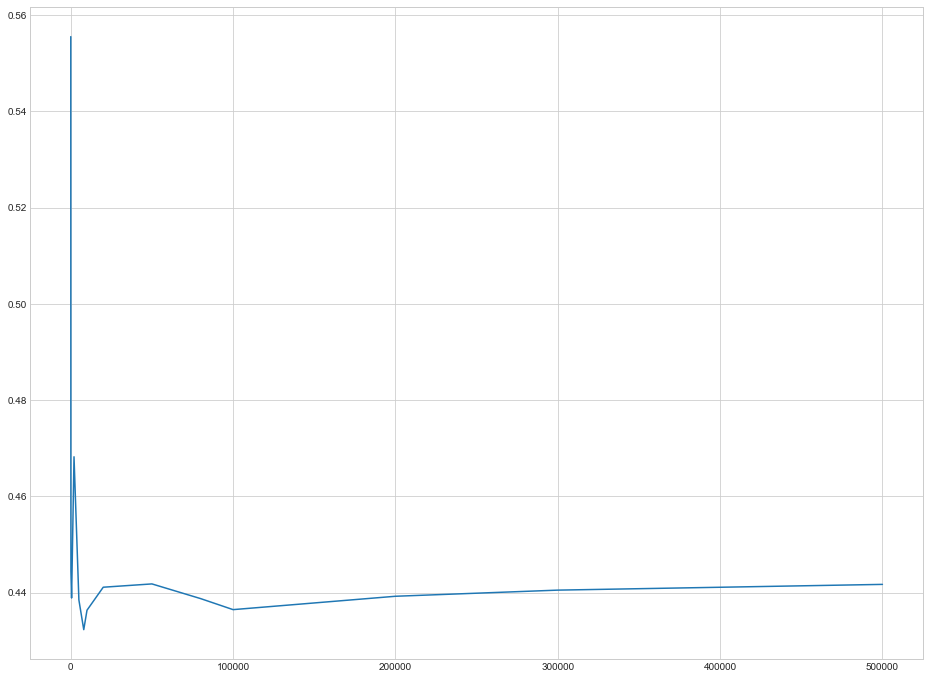

In [194]:
mc_engine.visualize_errors(expected_payoffs, x=n_simulations)

## 2.2 A naive option valuation surface (S, E, Sigma versus expected terminal values)

below is a naive limited valuation surface, with asset prices and strike as 50 to 150 (10 increment), volatility 5% to 30% (5% increment) and Time to expiry 0.5, 1.0, 1.5 years, and I'm going to plot a few graphs based on this. 

In [ ]:
call_option_prices = dict()
put_option_prices = dict()

for s in range(50, 180, 5):
    for e in range(50, 180, 5):
        for sigma in range(5, 60, 2):
            for t in [0.5, 1.0, 1.5]:
                option = BinaryOption(S=s, E=e, r=0.05, sigma=sigma*0.01, T=t, option_type=OptionType.Call)
                mc_engine = MCEngine(option)
                results, errors = mc_engine.simulate_until_converge(steps=200, on = "option_payoff", epsilon=0.002)
                call_option_prices[(s, e, sigma*0.01, t)] = results
                put_option_prices[(s, e, sigma*0.01, t)] = 1-results

And this is a quick look at the data: 

In [402]:
import pandas as pd
call = pd.DataFrame(call_option_prices.values(), columns=['expected_terminal_call_value'])
call.index= call_option_prices.keys()
put = pd.DataFrame(put_option_prices.values(), columns=['expected_terminal_put_value'])
put.index= put_option_prices.keys()
valuation_surface = call.merge(put, left_index=True, right_index=True)
valuation_surface.index.names = ['asset_price', 'strike', 'volatility','expiry']
valuation_surface['moneyness'] = valuation_surface.index.get_level_values('asset_price') - valuation_surface.index.get_level_values('strike') 
valuation_surface.sort_index(inplace=True)
valuation_surface

expected_terminal_call_value  \
asset_price strike volatility expiry                                 
50          50     0.05       0.5                         0.755918   
                              1.0                         0.835920   
                              1.5                         0.883519   
                   0.10       0.5                         0.625211   
                              1.0                         0.671997   
...                                                            ...   
155         100    0.20       1.5                         0.974264   
160         100    0.20       1.5                         0.978578   
165         100    0.20       1.5                         0.990301   
170         100    0.20       1.5                         0.991410   
175         100    0.20       1.5                         0.992231   

                                      expected_terminal_put_value  moneyness  
asset_price strike volatility expiry                                          
50          50     0.05       0.5                        0.244082          0  
                              1.0                        0.164080          0  
                              1.5                        0.116481          0  
                   0.10       0.5                        0.374789          0  
                              1.0                        0.328003          0  
...                                                           ...        ...  
155         100    0.20       1.5                        0.025736         55  
160         100    0.20       1.5                        0.021422         60  
165         100    0.20       1.5                        0.009699         65  
170         100    0.20       1.5                        0.008590         70  
175         100    0.20       1.5                        0.007769         75  

[1557 rows x 3 columns]

### volatility vs expected terminal option value: 

below is a plot of volatility vs expected terminal option value when expiry is 1.5 and r=0.05: 

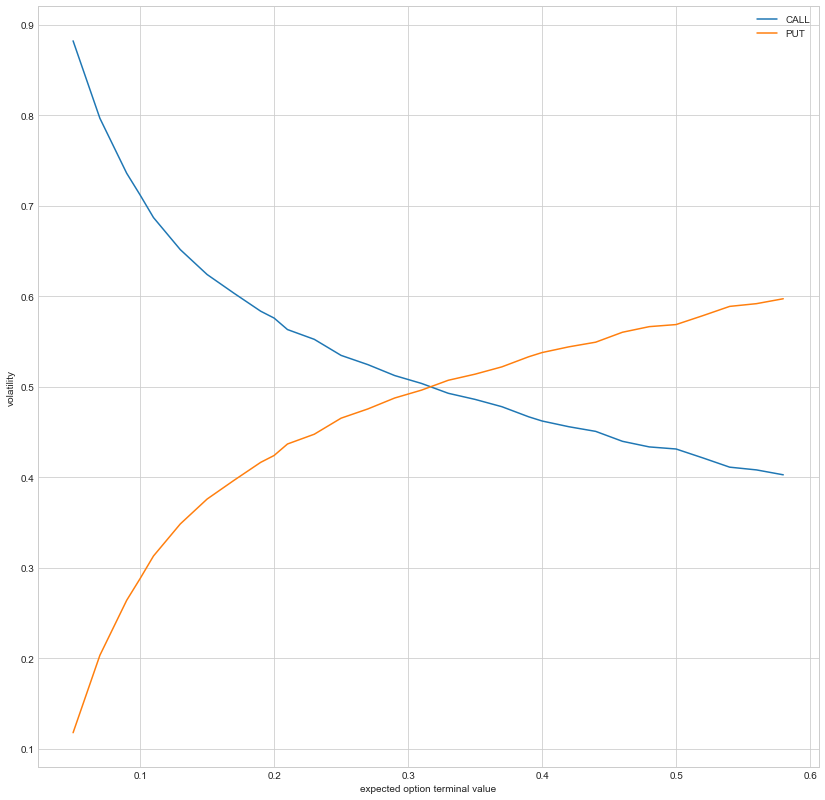

In [403]:
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

# get exipry=1.5 data 
x = valuation_surface[(valuation_surface.index.get_level_values('expiry') == 1.5) & 
                      (valuation_surface.index.get_level_values('strike') == 100) & 
                      (valuation_surface.index.get_level_values('asset_price') == 100)]

fig = plt.figure(figsize=(14,14))
ax = plt.axes()
ax.plot(x['expected_terminal_call_value'].index.get_level_values('volatility'), x['expected_terminal_call_value'])
ax.plot(x['expected_terminal_call_value'].index.get_level_values('volatility'), x['expected_terminal_put_value'])
ax.plot(title = 'volatility vs expected terminal option value')
ax.set_xlabel("expected option terminal value")
ax.set_ylabel("volatility")
ax.legend(["CALL", "PUT"])
fig.show()

### underlying asset price(moneyness) vs expected terminal option value: 

below is a plot of underlying asset price vs terminal option value when expiry is 1.5 and r=0.05: 

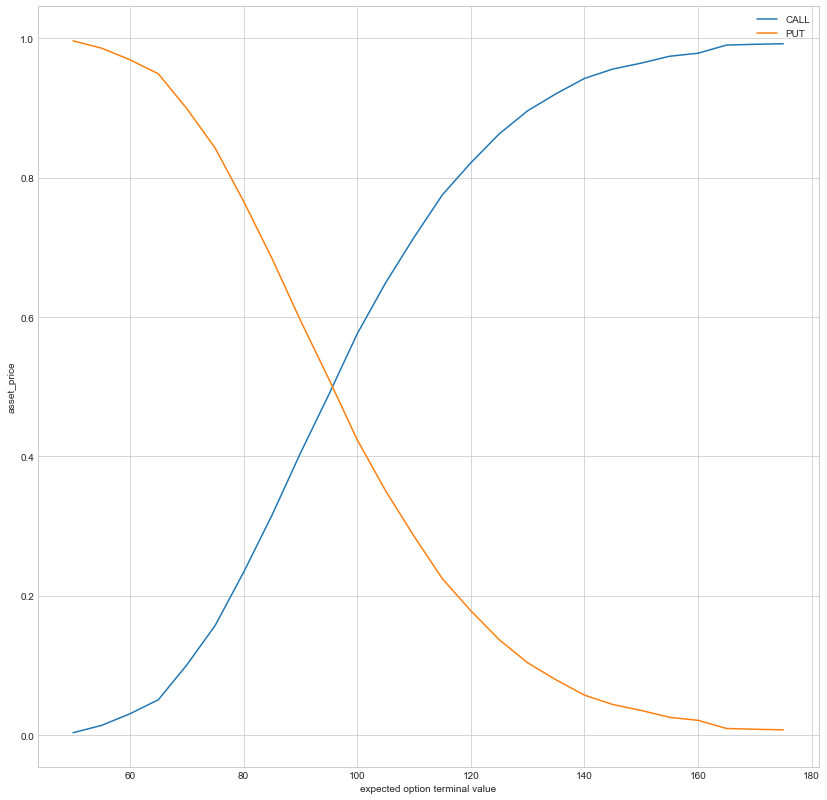

In [399]:
x = valuation_surface[(valuation_surface.index.get_level_values('expiry') == 1.5) & 
                      (valuation_surface.index.get_level_values('strike') == 100) & 
                      (valuation_surface.index.get_level_values('volatility') == 0.2)]

fig = plt.figure(figsize=(14,14))
ax = plt.axes()
ax.plot(x['expected_terminal_call_value'].index.get_level_values('asset_price'), x['expected_terminal_call_value'])
ax.plot(x['expected_terminal_call_value'].index.get_level_values('asset_price'), x['expected_terminal_put_value'])
ax.plot(title = 'volatility vs expected terminal option value')
ax.set_ylabel("expected option terminal value")
ax.set_xlabel("asset_price")
ax.legend(["CALL", "PUT"])
fig.show()

### strike price vs expected terminal option value: 

below is a plot of underlying asset price vs terminal option value when expiry is 1.5 and r=0.05: 

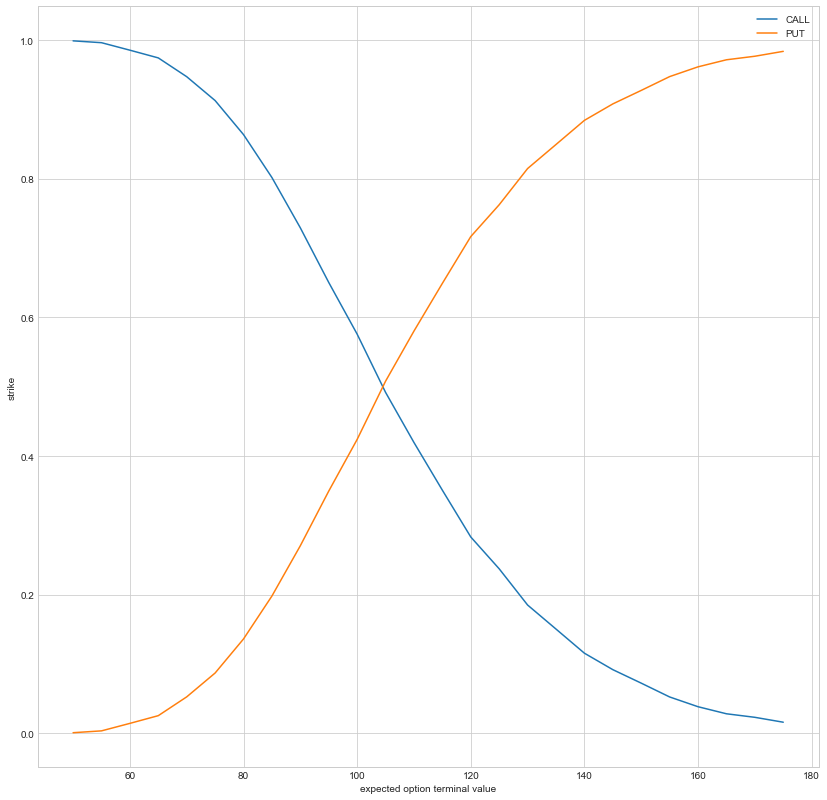

In [392]:
x = valuation_surface[(valuation_surface.index.get_level_values('expiry') == 1.5) & 
                      (valuation_surface.index.get_level_values('asset_price') == 100) & 
                      (valuation_surface.index.get_level_values('volatility') == 0.2)]

fig = plt.figure(figsize=(14,14))
ax = plt.axes()
ax.plot(x['expected_terminal_call_value'].index.get_level_values('strike'), x['expected_terminal_call_value'])
ax.plot(x['expected_terminal_call_value'].index.get_level_values('strike'), x['expected_terminal_put_value'])
ax.plot(title = 'volatility vs expected terminal option value')
ax.set_ylabel("expected option terminal value")
ax.set_xlabel("strike")
ax.legend(["CALL", "PUT"])
fig.show()